# Development Notebook

#### CCD Implementation

In [ ]:
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
from fibsem.structures import BeamType

import numpy as np
import matplotlib.pyplot as plt



microscope, settings = utils.setup_session(ip_address="10.0.0.1", manufacturer="Thermo")


In [ ]:

import napari
viewer = napari.Viewer()



In [ ]:
from pprint import pprint 

microscope.connection.imaging.set_active_view(4)
microscope.connection.imaging.set_active_device(3) #CCD = DEVICE 3, BUT VIEW=4 USUALLY WHAT?

import time
from fibsem.structures import FibsemImage


from napari.qt.threading import thread_worker


@thread_worker
def _acquire_image(microscope):
    i = 0
    images = []
    while True:

        print(f"Acquiring image... {i:04d}")
        image = microscope.connection.imaging.get_image()
        image = FibsemImage(image.data, None)
        # images.append(image)

        yield image
        
        time.sleep(0.2)
        i += 1
        if i > 100:
            break




def _on_yield(image):
    try:
        viewer.layers["data"].data = image.data
    except KeyError:
        viewer.add_image(image.data, name="data")


worker = _acquire_image(microscope)
worker.yielded.connect(_on_yield)
worker.finished.connect(lambda: print("Finished!"))
worker.finished.connect(viewer.close)
worker.start()



In [ ]:

# plot all images

fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
for i, image in enumerate(images):
    axes[i].imshow(image.data, cmap='gray')
    axes[i].set_title(f'Image {i}')
    axes[i].axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Metadata display utils

In [1]:
from fibsem.structures import FibsemImage, BeamType
import fibsem.utils as utils

In [4]:
img = FibsemImage.load(r"C:\Users\lnae0002\Desktop\fibsem\fibsem\log\default_image_eb.tif")
print(img.metadata.microscope_state.eb_settings.voltage)
timezone = 'Australia/Sydney'

20000.0


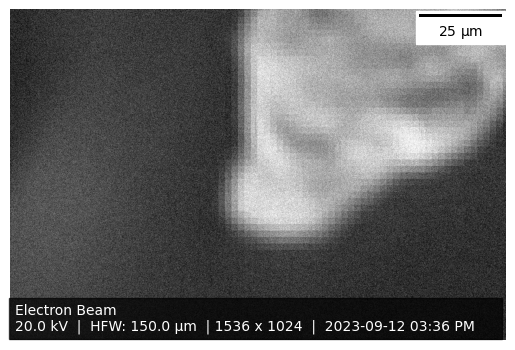

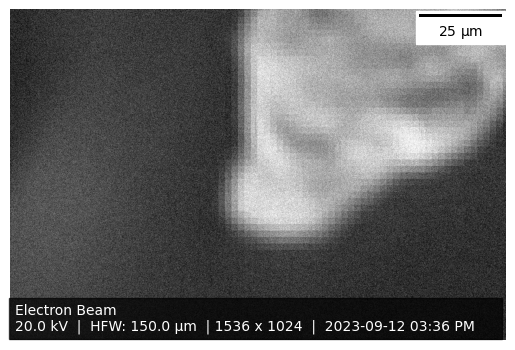

In [5]:
utils._display_metadata(img, timezone=timezone, show=True)